# AI@University - Preparation Material
This preparation material aims to give you an intuition on the activities and skills needed during the upcoming workshop at your university. The center piece of this workshop will be a compact hacking competition, in which you solve a given customer case in small groups, using Machine Learning. This notebook illustrates the general approach to solving such a case study, and it is recommended to follow a similar structure during the hacking competition of the workshop.

### Prerequisites
Familiarity with the **Python 3** programming language, related libraries, such as **pandas**, **numpy** or **scikit-learn**, as well as **Jupyter Notebooks** are required. So before the workshop, please make sure that you have installed Python 3 and Juypter Notebooks, preferrably using the [Anaconda distribution](https://www.anaconda.com/download/#macos), as it already contains a set of useful Data Science libraries.

**Note**:
* When downloading this file to macOS, it automatically gets converted to a text file. To be able to open it as a Jupyter Notebook, select the file and press `command` + `i`. In the opening detail view, delte the file ending `.txt`

# Case Study: Thomas J. Watson Hospital - Oncology Department
You have been hired as a consulting team of Data Scientists by the oncology department of the **Thomas J. 
Watson Hospital** in **Berlin**.

The oncology department is highly recognized and attracts patients from all over the world
due to its exceptional and effective treatment methods.

To maintain its excellent reputation and pioneer in the area of cancer treatment, the Thomas J. Watson hospital
setup a new Technology Council with the goal to investigate future-oriented technologies to support its oncologists. Concretely, the Council agreed to target the identification of breast cancer in its early stages, which enables treating the disease more effectively.

You have been engaged by the Technology Counsil to find a solution that assists the oncologists in classifying whether a breast tumor is 
**malignant** or **benign**.

You should present your results to the hospital board coming Friday. Keep in mind to present your findings in a way
that both business and technical stakeholders feel addressed.

### Data
This breast cancer databases was obtained from the University of Wisconsin Hospitals, Madison from Dr. William H. Wolberg:

**Wisconsin Breast Cancer Database** (January 8, 1991), O. L. Mangasarian and W. H. Wolberg: "Cancer diagnosis via linear programming", SIAM News, Volume 23, Number 5, September 1990, pp 1 & 18, link: https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/

### Data Dictionary
All attributes, except the target value (`class`) are numeric and range from `1` to `10`.

Attribute|Description
---|---
sample_code_number|ID number of sample
clump_thickness|In the Clump thickness benign cells tend to be grouped in monolayers, while cancerous cells are often grouped in multilayer.
uniformity_of_cell_size|While in the Uniformity of cell size/shape the cancer cells tend to vary in size and shape. That is why these parameters are valuable in determining whether the cells are cancerous or not. 
uniformity_of_cell_shape|see above
marginal_adhesion|In the case of Marginal adhesion the normal cells tend to stick together, where cancer cells tend to lose this ability. So loss of adhesion is a sign of malignancy.
single_epithelial_cell_size|In the Single epithelial cell size the size is related to the uniformity mentioned above. Epithelial cells that are significantly enlarged may be a malignant cell.
bare_nuclei|The Bare nuclei is a term used for nuclei that is not surrounded by cytoplasm (the rest of the cell). Those are typically seen in benign tumors. 
bland_chromatin|The Bland Chromatin describes a uniform "texture" of the nucleus seen in benign cells. In cancer cells the chromatin tends to be coarser. 
normal_nucleoli|The Normal nucleoli are small structures seen in the nucleus. In normal cells the nucleolus is usually very small if visible. In cancer cells the nucleoli become more prominent, and sometimes there are more of them. 
mitoses|Finally, Mitoses is nuclear division plus cytokines and produce two identical daughter cells during prophase. It is the process in which the cell divides and replicates. Pathologists can determine the grade of cancer by counting the number of mitoses
class|Label: Benign=2, Malignant=4

### Medical Background
Breast cancer is the most common cancer among women and one of the major causes of death worldwide.
Every year approximately 124 out of 100,000 women are diagnosed with breast cancer, and the estimation is that 23 out of the 124 women will die of this disease. When  detected  in  its  early  stages,  there  is  a  30%  chance that  the cancer can be treated effectively, but the late detection of advanced-stage tumors makes the treatment more difficult.

# Setup

In [2]:
from time import time
from collections import Counter
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_validate
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Data
Specify in which directory the input data is kept.

In [3]:
data_directory = Path('../raw_data/challenge_data')

## Training Data

In [4]:
data = pd.read_csv(data_directory / 'breast_cancer_train.csv')
print(data.shape[1] - 1,'features and',data.shape[0],'training examples')
data.head()

10 features and 559 training examples


,sample_code_number,uniformity_of_cell_shape,uniformity_of_cell_size,clump_thickness,bare_nuclei,cell_size,normal_nucleoli,clump_cohesiveness,nuclear_chromatin,mitoses,class
0,557583,5,10,10,10,10,10,10,1,1,4
1,1230688,7,4,7,4,3,7,7,6,1,4
2,787451,5,1,2,1,2,1,1,1,1,2
3,1238777,1,1,1,1,2,1,1,1,1,2
4,1371026,5,10,10,10,4,10,5,6,3,4


## Validation Data
As we can see, that validation data is missing values for the target value `class`, which should be predicted by our algorithm.

In [5]:
data_validation = pd.read_csv(data_directory / 'breast_cancer_validation.csv')
print(data.shape[1] - 1,'features and',data_validation.shape[0],'validation examples')
data_validation.head()

10 features and 140 validation examples


,sample_code_number,uniformity_of_cell_shape,uniformity_of_cell_size,clump_thickness,bare_nuclei,cell_size,normal_nucleoli,clump_cohesiveness,nuclear_chromatin,mitoses,class
0,1056171,2,1,1,1,2,1,2,1,1,NaN
1,1179818,2,1,1,1,2,1,3,1,1,NaN
2,1334015,7,8,8,7,3,10,7,2,3,NaN
3,1287282,3,1,1,1,2,1,1,1,1,NaN
4,1265899,4,1,1,1,2,1,3,1,1,NaN


# Data Preparation

Concatenate `data` and `validation data` in a list to process them simultaneously.

In [6]:
data_preprocessor = [data, data_validation]

## Feature Selection
Drop features that do not hold any value for the analysis.

In [7]:
for dataset in data_preprocessor:
    dataset.drop('sample_code_number',axis=1,inplace=True)

## Imputation
Check whether the data contains any null / NaN values or if any values do not correspond to the anticipated datatypes.

In [8]:
data.isnull().sum()

uniformity_of_cell_shape    0
uniformity_of_cell_size     0
clump_thickness             0
bare_nuclei                 0
cell_size                   0
normal_nucleoli             0
clump_cohesiveness          0
nuclear_chromatin           0
mitoses                     0
class                       0
dtype: int64

In [9]:
data.dtypes

uniformity_of_cell_shape     int64
uniformity_of_cell_size      int64
clump_thickness              int64
bare_nuclei                  int64
cell_size                    int64
normal_nucleoli             object
clump_cohesiveness           int64
nuclear_chromatin            int64
mitoses                      int64
class                        int64
dtype: object

The feature column `normal_nucleoli` is of datatype `object`, although it should contain only digits. Let's check which non-digit values can be found in the dataframe using the `isdigit()` function of pandas.

In [10]:
data[~data['normal_nucleoli'].str.isdigit()][['normal_nucleoli']].head()

,normal_nucleoli
33,?
48,?
65,?
89,?
104,?


Subsequently, let's replace all non-digit values with the median value and make the column numerical.

In [11]:
pattern = r'(\D+)'
replacement = str(int(data[data['normal_nucleoli'].str.isdigit()]['normal_nucleoli'].astype(int).median()))

for dataset in data_preprocessor:
    dataset['normal_nucleoli'] = dataset['normal_nucleoli'].str.replace(pat = pattern, repl = replacement).astype(int)

Generally, in the data preparation phase, you should focus on **Correcting**, **Completing** and **Converting** your existing data, as well as considering **Creating** new data (*feature engineering*) which might improve your predictions.

# Data Exploration

## Target Distribtion
Check whether the target distribution is skewed.

In [24]:
data['class'].value_counts()

2    369
4    190
Name: class, dtype: int64

## Feature Correlations
Check the correlation amongst the attributes to determine strong predictors amongst the features. This help to put the model's output into context and start further investigations to improve the performance.

In [12]:
correlation_matrix = data.corr()

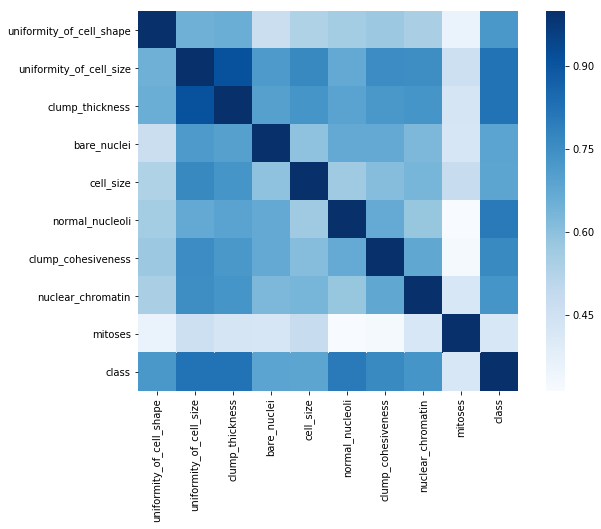

In [29]:
fig = plt.figure(figsize=(10, 7))
ax = plt.axes()
ax = sns.heatmap(correlation_matrix, mask=np.zeros_like(correlation_matrix, dtype=np.bool), cmap="Blues", square=True, ax = ax)
plt.show()

# Modeling

## Define Features and Target
Specify for the training set which columns contain the features (`X`) and which column contains the target (`y`). Note, that for the validation set we only need to specify the feature columns (`X_validation`) we use for prediction, since the target is not know to us and has to be predicted by our model.

In [15]:
X = data[data.columns[:-1]]
y = data[data.columns[-1]]

X_validation = data_validation[data_validation.columns[:-1]]

## Model Selection
Define a list of algorithm classes that should be investigated. For this example, we are only considering a Support Vector Machine with a linear kernel. Feel free to consider more algorithms by importing the respective module and adding the respective model class to the `algorithms` list.

In [16]:
algorithms = [
    LinearSVC()
]

In [1]:
def model_selection(X, y, algorithms, n_splits=10, test_size=.3, train_size=.6, random_state=0):
    """Select the most accurate machine learning model from a given list.

    Parameters
    ----------
    X : array-like
        dataFrame to fit
    y : array-like
        target variable to predict
    algorithms : array-like
        scikit-learn model objects
    n_splits : int
        number of re-shuffling & splitting iterations
    test_size : float, int
        proportion of the dataset to include in the test split
    train_size : float, int
        proportion of the dataset to include in the train split
    random_state : int
        random seed
    
    Returns
    -------
    algorithm_comparision : array-like
        dataframe containing the algorithm's attributes and accuracy 
    """
    # Define the cross-validation split, leaving out 10%
    cv_split = ShuffleSplit(n_splits=n_splits,test_size=test_size,
                            train_size=train_size,random_state=random_state)
    
    # Create a table to compare the algorithm's metrics and predictions
    columns = ['name','params','mean_train_accuracy','mean_test_accuracy','test_accuracy_3std' ,'time']
    algorithm_comparison = pd.DataFrame(columns = columns)

    row_index = 0
    
    for alg in algorithms:

        # Set name and parameters of the algorithm
        algorithm_name = alg.__class__.__name__
        algorithm_comparison.loc[row_index, 'name'] = algorithm_name
        algorithm_comparison.loc[row_index, 'params'] = str(alg.get_params())

        # Score model with cross validation using the accuracy metric
        cv_results = cross_validate(alg, X, y, cv=cv_split, scoring='accuracy', return_train_score=True)
        algorithm_comparison.loc[row_index, 'time'] = cv_results['fit_time'].mean()
        algorithm_comparison.loc[row_index, 'mean_train_accuracy'] = cv_results['train_score'].mean()
        algorithm_comparison.loc[row_index, 'mean_test_accuracy'] = cv_results['test_score'].mean()  
        algorithm_comparison.loc[row_index, 'test_accuracy_3std'] = cv_results['test_score'].std()*3

        row_index+=1

    algorithm_comparison.sort_values(by = ['mean_test_accuracy'], ascending = False, inplace = True)
    
    return algorithm_comparison

In [2]:
model_selection(X,y,algorithms)

NameError: name 'X' is not defined

After conducting the model selection, it is possible to conduct a hyperparameter search to improve the model performance even further. As this can be quite time consuming, it is recommended to take the default model parameter values.

## Train Final Model
Before generating the final predictions, we want to train our model on **all** the data we have available.

In [19]:
model = LinearSVC()

In [20]:
model.fit(X,y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

# Prediction on Validation Set

Finally, let's put our model to work and predict on the validation data.

In [40]:
y_pred = model.predict(X_validation)

print('Number of Predictions:',len(y_pred))
print('Prediction Contents:',y_pred[:10])

Number of Predictions: 140
Prediction Contents: [2 2 4 2 2 4 2 4 4 4]


Save the predictions as a csv file and name it after your team, so they can be submitted for evaluation.

In [22]:
pd.Series(y_pred).to_csv(data_directory / 'YOUR_TEAM_NAME.csv',sep=',',index=False)

**Author**: Daniel Jaeck, Data Scientist at IBM (daniel.jaeck@de.ibm.com)

Copyright © IBM Corp. 2018. This notebook and its source code are released under the terms of the MIT License.